<a href="https://colab.research.google.com/github/Teasotea/Age-Rate-Classifier-NLP/blob/main/Other_features_dense_age_rate_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Dense Age Rate Classifier



###TODO: Build a dense neural net to classify  movies by their age rate.

In [ ]:
pip install geotext


In [ ]:
! pip install kaggle

In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
import os
import io
import json

import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import model_selection
from sklearn.preprocessing import LabelEncoder 
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
from tensorflow.keras.preprocessing.sequence import pad_sequences 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.layers import Embedding 
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.preprocessing.text import Tokenizer

import nltk
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import names
from nltk.corpus import stopwords
from nltk.stem.porter import *
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('names')
from geotext import GeoText
import string

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package names to /root/nltk_data...
[nltk_data]   Package names is already up-to-date!


#Load Data

In [ ]:
dataset_url = 'https://raw.githubusercontent.com/Teasotea/Age-Rate-Classifier-NLP/main/IMDB_data.csv'
df = pd.read_csv(dataset_url)
df.head()

,Unnamed: 0,Name of movie,Description,Age rate,Year,Runtime,Genre
0,0,The Shawshank Redemption,Two imprisoned men bond over a number of years...,R,1994,142,Drama
1,1,The Godfather,The Godfather follows Vito Corleone Don of the...,R,1972,175,"Crime, Drama"
2,2,Pulp Fiction,"The lives of two mob hitmen, a boxer, a gangst...",R,1994,154,"Crime, Drama"
3,3,The Godfather: Part II,The early life and career of Vito Corleone in ...,R,1974,202,"Crime, Drama"
4,4,Inception,A thief who steals corporate secrets through t...,PG-13,2010,148,"Action, Adventure, Sci-Fi"


In [ ]:
is_r = list()
for i in df['Age rate']:
  if i=='R': is_r.append(1)
  else: is_r.append(0)
print(is_r.count(0), ":", is_r.count(1))

447 : 338


#Load data2

In [ ]:
! kaggle datasets download lukelarue/movie-attributes-for-3400-movies-from-20002020
! unzip movie-attributes-for-3400-movies-from-20002020.zip

movie-attributes-for-3400-movies-from-20002020.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  movie-attributes-for-3400-movies-from-20002020.zip
  inflating: Attributes_DataFrame.csv  
  inflating: Daily_DataFrame.csv     


In [ ]:
kaggle_df = pd.read_csv("Attributes_DataFrame.csv")
k_dataset = kaggle_df.drop(['Domestic','International', 'Budget'], axis=1)
k_dataset.head()

,Title,Distributor,MPAA-Rating,Runtime,Genres
0,Jurassic World (2015),Universal Pictures,PG-13,124,Action;Adventure;Sci-Fi
1,Star Wars: Episode VII - The Force Awakens (2015),Walt Disney Studios Motion Pictures,PG-13,138,Action;Adventure;Sci-Fi
2,Avengers: Age of Ultron (2015),Walt Disney Studios Motion Pictures,PG-13,141,Action;Adventure;Sci-Fi
3,Inside Out (2015),Walt Disney Studios Motion Pictures,PG,95,Adventure;Animation;Comedy;Drama;Family;Fantasy
4,Furious 7 (2015),Universal Pictures,PG-13,137,Action;Adventure;Thriller


#Remove stopwords and punctuation

In [ ]:
#define stop words: english stop words, numbers, male and female names
numbers = ['one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine', 'ten', 'eleven', 'twelve', 	'thirteen', 'fourteen', 'fifteen', 
'sixteen', 'seventeen', 'eighteen', 'nineteen', 'twenty', 'thirty', 'forty', 'fifty', 'sixty', 'seventy', 'eighty', 'ninety', 'hundred']
stpwrds = stopwords.words('english') + [i.lower() for i in names.words('male.txt') + names.words('female.txt')] + numbers
data = [n.lower() for n in df['Name of movie']]
for i in range(len(data)):
  data[i] += " " + df['Description'][i].lower()
data2 = []

#remove city names from description
for i in range(len(df['Name of movie'])):
  places = GeoText(df['Name of movie'][i])
  if places.cities != []:
    for j in places.cities:
      data[i] = data[i].replace(j.lower(), '')


for i in data:
  #remove punctuation and split
  tr= str.maketrans(dict.fromkeys(string.punctuation))
  new_i = i.translate(tr)
  descr = new_i.split(sep=' ')

  #remove stop words or numbers
  for k in range(10):
    for j in descr:
      if j in stpwrds or j!= '' and j[0].isdigit():
        descr.remove(j)
    if "" in descr:
      descr.remove("")
  data2.append(descr)

print(df['Name of movie'][348], ": ",df['Description'][348] )
print(data2[348])


The Hitchhiker's Guide to the Galaxy :  Mere seconds before the Earth is to be demolished by an alien construction crew, journeyman Arthur Dent is swept off the planet by his friend Ford Prefect, a researcher penning a new edition of "The Hitchhiker's Guide to the Galaxy."
['hitchhikers', 'guide', 'galaxy', 'mere', 'seconds', 'earth', 'demolished', 'alien', 'construction', 'crew', 'journeyman', 'dent', 'swept', 'planet', 'friend', 'prefect', 'researcher', 'penning', 'new', 'edition', 'hitchhikers', 'guide', 'galaxy']


#Stem words

In [ ]:
stemmer = PorterStemmer()
for i in range(len(data2)):
  data2[i] = [stemmer.stem(w.lower()) for w in data2[i]]
print(data2[3])

['godfath', 'part', 'ii', 'earli', 'life', 'career', 'corleon', 'new', 'york', 'citi', 'portray', 'expand', 'tighten', 'grip', 'famili', 'crime', 'syndic']


In [ ]:
for i in range(len(data2)):
  data2[i].extend(df['Genre'][i].replace(' ', '').lower().split(','))
  data2[i].append(str(df['Runtime'][i]))
  data2[i].append(str(df['Year'][i]))
  data2[i].append(str(df['Unnamed: 0'][i]))
print(data2)
short_df = pd.DataFrame(list(zip(data2, is_r)),
               columns =['name', 'age rate'])

short_df.head()
#with pd.option_context('display.max_rows', None, 'display.max_columns', None):
#     print(short_df)

[['shawshank', 'redempt', 'imprison', 'men', 'bond', 'number', 'year', 'find', 'solac', 'eventu', 'redempt', 'act', 'common', 'decenc', 'drama', '142', '1994', '0'], ['godfath', 'godfath', 'follow', 'corleon', 'corleon', 'famili', 'pass', 'mantel', 'crime', 'drama', '175', '1972', '1'], ['pulp', 'fiction', 'live', 'mob', 'hitmen', 'boxer', 'gangster', 'wife', 'pair', 'diner', 'bandit', 'intertwin', 'tale', 'violenc', 'redempt', 'crime', 'drama', '154', '1994', '2'], ['godfath', 'part', 'ii', 'earli', 'life', 'career', 'corleon', 'new', 'york', 'citi', 'portray', 'expand', 'tighten', 'grip', 'famili', 'crime', 'syndic', 'crime', 'drama', '202', '1974', '3'], ['incept', 'thief', 'steal', 'corpor', 'secret', 'use', 'dreamshar', 'technolog', 'given', 'invers', 'task', 'plant', 'idea', 'mind', 'ceo', 'tragic', 'past', 'doom', 'project', 'team', 'disast', 'action', 'adventure', 'sci-fi', '148', '2010', '4'], ['lord', 'ring', 'return', 'gandalf', 'aragorn', 'lead', 'world', 'men', 'sauron', '

,name,age rate
0,"[shawshank, redempt, imprison, men, bond, numb...",1
1,"[godfath, godfath, follow, corleon, corleon, f...",1
2,"[pulp, fiction, live, mob, hitmen, boxer, gang...",1
3,"[godfath, part, ii, earli, life, career, corle...",1
4,"[incept, thief, steal, corpor, secret, use, dr...",0


# Hyperparameters


In [ ]:
# output directory name:
output_dir = 'model_output/dense'

embedding_dim = 64
max_features=10000
maxlen=30

####
# training:
epochs = 4#4
batch_size = 32#784

# vector-space embedding: 
n_dim = 64
n_unique_words = 5000 # as per Maas et al. (2011); may not be optimal
#n_words_to_skip = 50 # ditto
max_decription_length = 100 #max_review_length (amount of tokens(words))
pad_type = trunc_type = 'pre' #could be 'post'

# neural network architecture: 
n_dense = 64 #neurons
dropout = 0.5 #drop 50% of neurons 





# Tokenizer

In [ ]:
#tokenizer of descriptions
t  = Tokenizer(num_words=max_features)
t.fit_on_texts([x for x in short_df['name']])
print(len(t.word_index))
os.makedirs(output_dir, exist_ok=True)
with io.open(output_dir+'/tokenizer.json', 'w',encoding='utf-8', ) as f:
    f.write(json.dumps(t.to_json(),ensure_ascii=False))
vocab_size = len(t.word_index) + 1
num_categories = 1


4742


In [ ]:
descr_sequences = t.texts_to_sequences([x for x in np.array(short_df['name'])])
descr_sequences = tf.keras.preprocessing.sequence.pad_sequences(descr_sequences, maxlen=maxlen)
print(descr_sequences[0])
print('sequences : ',descr_sequences,'\n')
print('word_index : ',t.word_index)
print(np.array(descr_sequences))

[   0    0    0    0    0    0    0    0    0    0    0    0 1994  908
  680  124  175  909   49   11  910  911  908  340 1995 1996    3  565
  137 1997]
sequences :  [[   0    0    0 ...  565  137 1997]
 [   0    0    0 ...  912 1999 2000]
 [   0    0    0 ...  685  137 2003]
 ...
 [   0    0    0 ...  754   16 4737]
 [   0    0    0 ...  159   23 4739]
 [   0    0    0 ...  181   32 4742]] 

word_index :  {'action': 1, 'comedy': 2, 'drama': 3, 'adventure': 4, 'crime': 5, 'thriller': 6, 'horror': 7, 'sci-fi': 8, 'fantasy': 9, 'mystery': 10, 'find': 11, 'must': 12, 'family': 13, 'new': 14, 'romance': 15, '2007': 16, 'man': 17, 'world': 18, '2004': 19, 'life': 20, 'young': 21, '2008': 22, '2005': 23, '2003': 24, 'group': 25, 'animation': 26, '2002': 27, 'becom': 28, '2006': 29, 'famili': 30, '2001': 31, '2009': 32, 'live': 33, 'help': 34, 'kill': 35, 'friend': 36, 'war': 37, 'discov': 38, 'citi': 39, 'mysteri': 40, 'agent': 41, 'dead': 42, 'murder': 43, 'forc': 44, 'tri': 45, 'team': 46

#Split data into train and test 

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(descr_sequences, short_df['age rate'], test_size=0.1, random_state=42)


print(np.array(X_train))

[[   0    0    0 ...  122   22 3161]
 [1448  206 1449 ...  129   56  122]
 [   0    0    0 ... 1360   19 2192]
 ...
 [   0    0    0 ...  169   23 2911]
 [   0    0    0 ...  375   82 3487]
 [   0    0    0 ...  372   22  164]]


In [ ]:
l = len(X_train[363])
print(l)

30


# Model and Train

In [ ]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Embedding(input_dim=vocab_size,
                           output_dim=embedding_dim,
                           input_length=maxlen),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(2000,activation='relu'),
  tf.keras.layers.Dense(500,activation='relu'),
  tf.keras.layers.Dense(100,activation='relu'),
  tf.keras.layers.Dense(num_categories, activation=tf.nn.sigmoid)
])

model.compile(optimizer='nadam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

modelcheckpoint = tf.keras.callbacks.ModelCheckpoint(filepath=output_dir+
                                  "/weights.{epoch:02d}.hdf5")

model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_12 (Embedding)    (None, 30, 64)            303552    
                                                                 
 flatten_12 (Flatten)        (None, 1920)              0         
                                                                 
 dense_48 (Dense)            (None, 2000)              3842000   
                                                                 
 dense_49 (Dense)            (None, 500)               1000500   
                                                                 
 dense_50 (Dense)            (None, 100)               50100     
                                                                 
 dense_51 (Dense)            (None, 1)                 101       
                                                                 
Total params: 5,196,253
Trainable params: 5,196,253
N

In [ ]:
#embedding level
n_dim, n_unique_words, n_dim*n_unique_words

(64, 5000, 320000)

In [ ]:
#flatten
max_decription_length, n_dim, n_dim*max_decription_length

(100, 64, 6400)

In [ ]:
#dense
n_dense, n_dim*max_decription_length*n_dense+n_dense #weights + biases

(64, 409664)

In [ ]:
#output
n_dense + 1

65

#Configure model

In [ ]:
model.compile(loss='binary_crossentropy', optimizer='nadam', metrics=['accuracy'])


modelcheckpoint = ModelCheckpoint(filepath=output_dir+
                                  "/weights.{epoch:02d}.hdf5")
callbacks=[modelcheckpoint]



if not os.path.exists(output_dir):
    os.makedirs(output_dir)

model.fit(X_train.astype('float32'),
          np.array(y_train).astype('float32').reshape((-1,1)), 
          batch_size=batch_size, epochs=epochs, verbose=1, 
          validation_data=(X_test.astype('float32'), 
          np.array(y_test).astype('float32').reshape((-1,1))), callbacks=callbacks)

Epoch 1/4
23/23 [==============================] - 4s 121ms/step - loss: 0.6153 - accuracy: 0.6586 - val_loss: 1.1467 - val_accuracy: 0.5696
Epoch 2/4
23/23 [==============================] - 3s 110ms/step - loss: 0.2747 - accuracy: 0.8824 - val_loss: 0.8952 - val_accuracy: 0.6456
Epoch 3/4
23/23 [==============================] - 3s 116ms/step - loss: 0.0141 - accuracy: 0.9986 - val_loss: 0.8837 - val_accuracy: 0.7215
Epoch 4/4
23/23 [==============================] - 3s 112ms/step - loss: 4.0454e-04 - accuracy: 1.0000 - val_loss: 0.9621 - val_accuracy: 0.7215


In [ ]:
score = model.evaluate(np.array(X_test), np.array(y_test)) 

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

3/3 [==============================] - 0s 12ms/step - loss: 0.9621 - accuracy: 0.7215
Test Score: 0.9621066451072693
Test Accuracy: 0.7215189933776855


# Accuracy

In [ ]:
model.load_weights(output_dir+"/weights.02.hdf5") # NOT zero-indexed

In [ ]:
y_hat = model.predict(X_test)

In [ ]:
len(y_hat)

79

In [ ]:
y_hat[3]

array([0.20320484], dtype=float32)

In [ ]:
print(np.array(y_test)[3])

1


In [ ]:
print(type(y_hat))

<class 'numpy.ndarray'>


In [ ]:
pct_auc = roc_auc_score(y_test, y_hat)*100.0
"{:0.2f}".format(pct_auc)

'80.68'

In [ ]:
float_y_hat = []
for y in y_hat:
    float_y_hat.append(y[0])

In [ ]:
ydf = pd.DataFrame(list(zip(float_y_hat, y_test)), columns=['y_hat', 'y'])
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
  print(ydf)

       y_hat  y
0   0.019127  0
1   0.023354  0
2   0.361453  1
3   0.203205  1
4   0.121746  0
5   0.158902  0
6   0.004337  0
7   0.023665  0
8   0.064669  1
9   0.042781  1
10  0.032939  0
11  0.836147  1
12  0.880292  1
13  0.073834  1
14  0.144433  0
15  0.290089  1
16  0.036004  1
17  0.041494  0
18  0.000937  0
19  0.668664  0
20  0.001818  0
21  0.007369  0
22  0.456018  1
23  0.841868  1
24  0.010937  1
25  0.123472  1
26  0.001323  0
27  0.050195  0
28  0.878012  1
29  0.708595  1
30  0.388455  0
31  0.164367  1
32  0.003512  0
33  0.067712  0
34  0.086761  1
35  0.231497  1
36  0.188417  1
37  0.056720  1
38  0.010611  0
39  0.407197  1
40  0.562125  1
41  0.635998  1
42  0.001369  0
43  0.047420  0
44  0.002929  0
45  0.524171  1
46  0.257398  1
47  0.397897  1
48  0.052154  1
49  0.100626  1
50  0.042183  0
51  0.045051  0
52  0.009044  0
53  0.023475  0
54  0.029721  1
55  0.028039  0
56  0.022759  0
57  0.045913  0
58  0.772750  1
59  0.048281  1
60  0.003382  0
61  0.01

In [ ]:
print(df.iloc[752])
print('Name:', df['Name of movie'][752])
print('Prediction:', y_hat[0])
print("Reality:", y_test.iloc[0])

Unnamed: 0                                                     752
Name of movie                                           Armageddon
Description      After discovering that an asteroid the size of...
Age rate                                                     PG-13
Year                                                          1998
Runtime                                                        151
Genre                        Action, Adventure, Sci-Fi            
Name: 752, dtype: object
Name: Armageddon
Prediction: [0.01912674]
Reality: 0


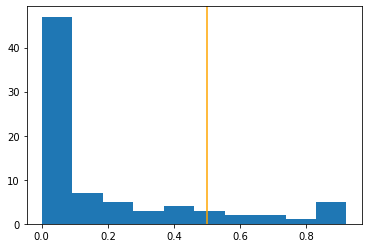

In [ ]:
plt.hist(y_hat)
_ = plt.axvline(x=0.5, color='orange')

In [ ]:
print(len(ydf[(ydf.y == 1) & (ydf.y_hat < 0.1)]))
print(len(y_test))

13
79


In [ ]:
ydf = pd.DataFrame(list(zip(float_y_hat, y_test)), columns=['y_hat', 'y'])
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(y_test)

752    0
39     0
211    1
199    1
235    0
215    0
547    0
601    0
299    1
137    1
323    0
218    1
174    1
506    1
168    0
67     1
517    1
688    0
525    0
781    0
753    0
446    0
286    1
335    1
23     1
247    1
599    0
377    0
613    1
429    1
618    0
771    1
490    0
678    0
97     1
346    1
585    1
516    1
692    0
779    1
635    1
350    1
580    0
683    0
653    0
714    1
120    1
86     1
654    1
78     1
621    0
780    0
649    0
49     0
77     1
231    0
433    0
66     0
260    1
329    1
545    0
640    0
30     0
591    1
33     1
31     0
582    0
417    0
314    0
751    0
762    0
676    1
309    0
302    1
705    0
326    0
234    0
606    0
362    1
Name: age rate, dtype: int64


In [ ]:
print(ydf[(ydf.y == 1) & (ydf.y_hat < 0.1)])

       y_hat  y
8   0.064669  1
9   0.042781  1
13  0.073834  1
16  0.036004  1
24  0.010937  1
34  0.086761  1
37  0.056720  1
48  0.052154  1
54  0.029721  1
59  0.048281  1
63  0.019415  1
71  0.001304  1
78  0.050536  1


In [ ]:
print(df.iloc[517])
print('Name:', df['Name of movie'][517])
print('Processed name:', data2[517])
print('Prediction:', y_hat[16])
print("Reality:", y_test.iloc[16])

Unnamed: 0                                                     517
Name of movie                           Rambo: First Blood Part II
Description      Rambo returns to the jungles of Vietnam on a m...
Age rate                                                         R
Year                                                          1985
Runtime                                                         96
Genre                      Action, Adventure, Thriller            
Name: 517, dtype: object
Name: Rambo: First Blood Part II
Processed name: ['rambo', 'first', 'blood', 'part', 'ii', 'rambo', 'return', 'jungl', 'vietnam', 'mission', 'infiltr', 'enemi', 'basecamp', 'rescu', 'american', 'pow', 'still', 'held', 'captiv', 'action', 'adventure', 'thriller', '96', '1985', '517']
Prediction: [0.03600365]
Reality: 1


In [ ]:
print(ydf[(ydf.y == 0) & (ydf.y_hat > 0.9)])
print(len(y_test))

Empty DataFrame
Columns: [y_hat, y]
Index: []
79


# Load/Save Model

In [ ]:
model.save(output_dir+'/model_v004')

INFO:tensorflow:Assets written to: model_output/dense/model_v004/assets
